In [1]:
from __future__ import print_function

# Standard modules
import os
import pickle
import numpy as np
import numpy.linalg as npl
import nibabel as nib

# Dipy modules
import dipy.viz.regtools as rt
import dipy.align.imwarp as imwarp
from dipy.align import VerbosityLevels
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import regtransforms

# EPI correction (new) modules
import dipy.correct.gradients as gr
from dipy.correct.splines import CubicSplineField
from dipy.correct.epicor import (OppositeBlips_CC_Motion,
                                 OffResonanceFieldEstimator)
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)
floating = np.float64

Populating the interactive namespace from numpy and matplotlib


In [2]:
def extend(vol):
    margin = 8
    half = margin // 2
    new_shape = np.array(vol.shape) + margin
    new_vol = np.zeros(shape = new_shape, dtype=np.float64)

    new_vol.shape
    new_vol[half:-half, half:-half, half:-half] = vol
    return new_vol

In [3]:
data_dir = '/home/omar/data/topup_example/'
up_fname = data_dir + "b0_blipup.nii"
down_fname = data_dir + "b0_blipdown.nii"

# Load data
up_nib = nib.load(up_fname)
up_affine = up_nib.get_affine()
up = up_nib.get_data().squeeze().astype(np.float64)
up = extend(up)
up /= up.mean()

down_nib = nib.load(down_fname)
down_affine = down_nib.get_affine()
down = down_nib.get_data().squeeze().astype(np.float64)
down = extend(down)
down /= down.mean()

dir_up, spacings_up = imwarp.get_direction_and_spacings(up_affine, 3)
dir_down, spacings_down = imwarp.get_direction_and_spacings(down_affine, 3)

spacings = spacings_down

In [4]:
# Configure and run orfield estimation
radius = 4
pedir_up = np.array((0,1,0), dtype=np.float64)
pedir_down = np.array((0,-1,0), dtype=np.float64)
distortion_model = OppositeBlips_CC_Motion(radius=radius)
level_iters = np.array([300, 300, 300, 300,
                        250, 200, 100], dtype=np.int32)
lambdas = np.array([0.0, 0.0, 0.0, 0.0,
                    0.01, 0.01, 0.005])*((radius+1)**3)*0.5
fwhm = np.array([8, 6, 4, 3,
                 2, 1, 0], dtype=np.float64)
step_lengths = np.array([0.1, 0.05, 0.05, 0.5,
                         0.05, 0.05, 0.05])
warp_res = np.array([20, 16, 14, 12,
                     6, 4, 4], dtype=np.float64)
subsampling = [2, 2, 2, 2,
               1, 1, 1]
    
estimator = OffResonanceFieldEstimator(distortion_model,
                                           level_iters=level_iters,
                                           lambdas=lambdas,
                                           fwhm=fwhm,
                                           step_lengths=step_lengths,
                                           warp_res=warp_res,
                                           subsampling=subsampling)


orfield_coef_fname = 'orfield_coef_trans_r4.p'


In [5]:
# Run OR-field estimation or load from file
orfield = None
if os.path.isfile(orfield_coef_fname):
    coef, R = pickle.load(open(orfield_coef_fname, 'r'))
    kspacing = np.round(estimator.warp_res[-1]/spacings)
    kspacing = kspacing.astype(np.int32)
    kspacing[kspacing < 1] = 1
    orfield = CubicSplineField(up.shape, kspacing)
    orfield.copy_coefficients(coef)
else:
    orfield, R = estimator.optimize_with_ss_motion(down, down_affine, pedir_down, up, up_affine, pedir_up, spacings)
    pickle.dump(tuple([np.array(orfield.coef), theta]), open(orfield_coef_fname, 'w'))



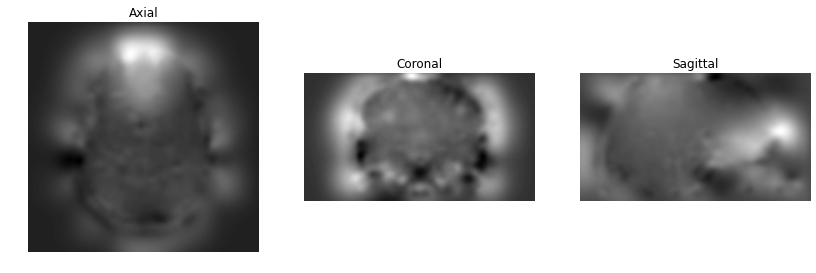

In [6]:
b  = np.array(orfield.get_volume((0, 0, 0)))
rt.plot_slices(b);

# Warp and modulte images
shape = np.array(down.shape, dtype=np.int32)
Ain = None
Aout = npl.inv(up_affine).dot(down_affine).dot(R)
Adisp = Aout
w_up, _m = gr.warp_with_orfield(up, b, pedir_up, Ain, Aout, Adisp, shape)

Ain = None
Aout = npl.inv(down_affine).dot(down_affine)
Adisp = Aout
w_down, _m = gr.warp_with_orfield(down, b, pedir_down, Ain, Aout, Adisp, shape)

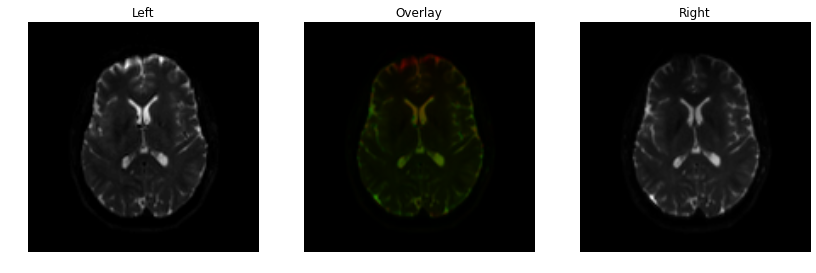

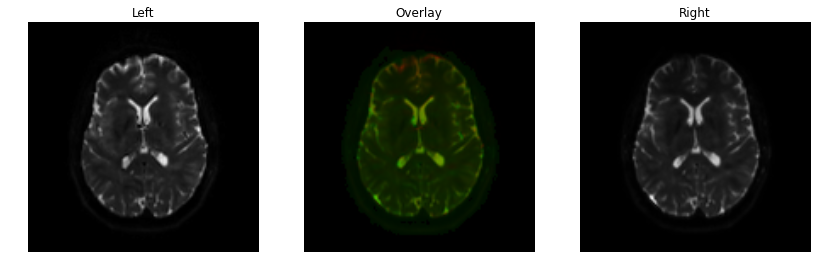

In [7]:

rt.overlay_slices(w_down, w_up, slice_type=2);
gb = np.zeros(shape=b.shape + (3,), dtype=np.float64)
gb[...,0] = orfield.get_volume((1,0,0))
gb[...,1] = orfield.get_volume((0,1,0))
gb[...,2] = orfield.get_volume((0,0,1))


Jdown = gb[...,0]*pedir_down[0] + gb[...,1]*pedir_down[1] + gb[...,2]*pedir_down[2] + 1
Jup = gb[...,0]*pedir_up[0] + gb[...,1]*pedir_up[1] + gb[...,2]*pedir_up[2] + 1
rt.overlay_slices(w_down*Jdown, w_up*Jup, slice_type=2);


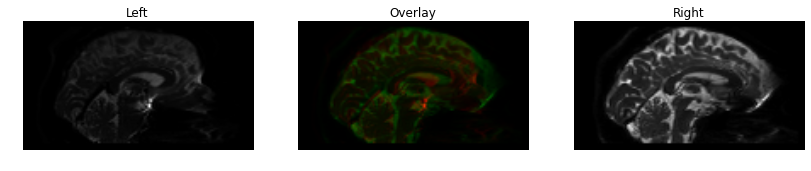

In [8]:
rt.overlay_slices(down, up, slice_type=0);

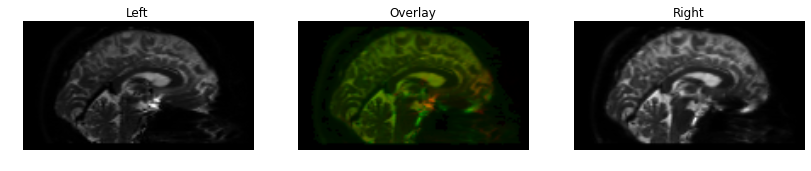

In [9]:
rt.overlay_slices(w_down*Jdown, w_up*Jup, slice_type=0);